In [30]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [33]:
import csv
labels_path = open('labels\labels.csv')
csvr = csv.reader(labels_path)
header = []
header = next(csvr)
rows = []
for row in csvr:
        rows.append(row)
labels_path.close()

imagenet_labels = np.array(rows)[:, 1].astype(np.int32)
print(imagenet_labels)
imagenet_labels = imagenet_labels.tolist()

[0 0 0 ... 8 8 8]


In [34]:
# import csv
# import shutil

# with open('labels/labels.csv', newline='') as csvfile:
#     reader = csv.reader(csvfile, delimiter=' ')
#     for row in reader:
#         x = row[0].split(',')
#         shutil.move("images_out/images/" + x[0], "images/" + x[1] + "/" + x[0])

In [35]:
# # data_root = './images'
# data_root = tf.keras.utils.get_file(
#   'flower_photos',
#   'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#    untar=True)

In [36]:
data_root = 'DeepWeeds\\images\\images'
# Dataset is from https://github.com/AlexOlsen/DeepWeeds
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 17509 files belonging to 9 classes.
Using 14008 files for training.
Found 17509 files belonging to 9 classes.
Using 3501 files for validation.


In [37]:
class_names = np.array(train_ds.class_names)
print(class_names)

['0' '1' '2' '3' '4' '5' '6' '7' '8']


In [38]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [39]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [44]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
resnet_50_v5 = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
feature_extractor_model = resnet_50_v5 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}



In [45]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [46]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [47]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,583,241
Trainable params: 18,441
Non-trainable params: 23,564,800
_________________________________________________________________


In [48]:
predictions = model(image_batch)

In [49]:
predictions.shape

TensorShape([32, 9])

In [50]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [51]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
438/438 [==============================] - 44s 93ms/step - loss: 1.0090 - acc: 0.6528 - val_loss: 0.8209 - val_acc: 0.7258
Epoch 2/10
438/438 [==============================] - 54s 123ms/step - loss: 0.7143 - acc: 0.7497 - val_loss: 0.7454 - val_acc: 0.7469
Epoch 3/10
438/438 [==============================] - 47s 107ms/step - loss: 0.6255 - acc: 0.7834 - val_loss: 0.7138 - val_acc: 0.7555
Epoch 4/10
438/438 [==============================] - 53s 121ms/step - loss: 0.5696 - acc: 0.8049 - val_loss: 0.6973 - val_acc: 0.7644
Epoch 5/10
438/438 [==============================] - 42s 96ms/step - loss: 0.5286 - acc: 0.8189 - val_loss: 0.6883 - val_acc: 0.7678
Epoch 6/10
438/438 [==============================] - 57s 129ms/step - loss: 0.4962 - acc: 0.8310 - val_loss: 0.6837 - val_acc: 0.7715
Epoch 7/10
438/438 [==============================] - 52s 118ms/step - loss: 0.4696 - acc: 0.8412 - val_loss: 0.6818 - val_acc: 0.7735
Epoch 8/10
438/438 [==============================] - 50s

In [52]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 19528), started 1:23:38 ago. (Use '!kill 19528' to kill it.)

In [53]:
y_pred = model.predict(train_ds)


In [54]:
prediction = np.argmax(y_pred, axis=1)
print(prediction)
true_categories = tf.concat([y for x, y in train_ds], axis=0)
print(true_categories)
tf.math.confusion_matrix(
    true_categories, prediction, num_classes=9, dtype=tf.dtypes.int32,
    name=None
)

[8 8 8 ... 5 6 4]
tf.Tensor([8 8 8 ... 5 6 4], shape=(14008,), dtype=int32)


<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[ 719,    9,    1,   13,    6,    1,    5,   23,  131],
       [  10,  663,    1,    4,    0,    3,   36,   19,  106],
       [   0,    1,  711,    5,   22,    0,    1,    0,   82],
       [   3,    2,    8,  620,   11,    3,    3,    2,  166],
       [   2,    0,   13,   19,  692,    1,    3,    0,  111],
       [   3,    9,    2,    2,    4,  673,   10,    6,   93],
       [   2,    2,    1,    0,    1,    2,  791,    0,   58],
       [  36,    8,    0,    4,    3,    2,   16,  601,  143],
       [  85,   36,   31,   71,   71,   40,  157,   32, 6782]])>

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

In [55]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

['8' '0' '8' '8' '8' '8' '6' '3' '4' '2' '2' '8' '8' '0' '8' '8' '8' '8'
 '0' '8' '8' '5' '5' '8' '7' '8' '8' '6' '5' '8' '8' '1']


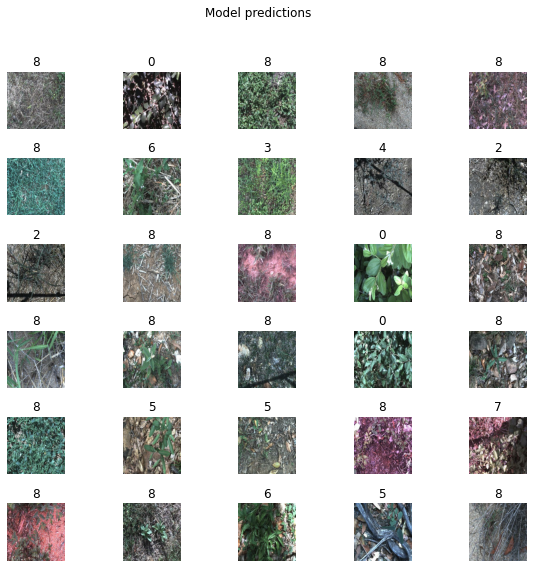

In [56]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [57]:
model.save('my_model.h5')
